# Auto-diff modeling of a `MOLET` simulation

__last updated__: 15/07/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
from scipy.optimize import minimize
from copy import deepcopy
from astropy.io import fits
from pprint import pprint

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import corner

# jaxtronomy imports
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util, param_util, molet_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
We use convenience functions to setup coordinates directly from MOLET input files.

__WARNING__: update the `model_dir` and possibly other paths to match the directories on your system.

In [2]:
molet_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Sparse_reconstruction/slitronomy/thirdparty/molet/'
molet_input_file = 'mock_4_autodiff_smooth/molet_input.json'
molet_instru_name = 'gaussianCAM'

pixel_grid = molet_util.get_pixel_grid_class(molet_dir, molet_input_file, molet_instru_name)

npix, npix_y = pixel_grid.num_pixel_axes
pix_scl = pixel_grid.pixel_width  # arcsec / pixel
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Load imaging data

0.007708352990448475


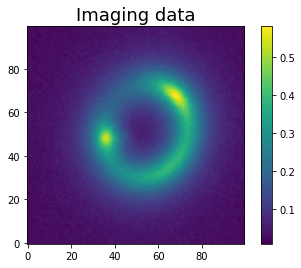

In [3]:
data_raw = molet_util.get_simulated_data(molet_dir, molet_input_file, molet_instru_name)

# uncomment this line to load a jaxtronomy-generated data
#data_raw = fits.getdata('data/simu_bkg0.01_expNone.fits').astype(float)

print(data_raw.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data_raw, origin='lower')
plt.colorbar()
plt.show()

### Noise

0.028861509636044502 0.019365520034261178 0.006948243193328381 0.5512651931494474


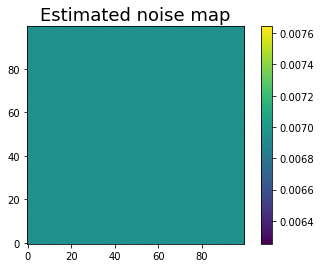

In [4]:
# select a portion believed to contain only noise
data_sky = data_raw[:, :10]
mean_sky = np.median(data_sky)

# TEST
snr = 100.
test_mean_sky = - np.min( np.max(data_raw)/snr * np.random.randn(npix, npix) )

# measure background noise
sigma_bkd = 1.48 * np.median(np.abs(data_sky - np.median(data_sky)))

# remove sky level
data = data_raw - mean_sky

print(mean_sky, test_mean_sky, sigma_bkd, data.max())

kwargs_noise = {'background_rms': sigma_bkd, 'noise_map': sigma_bkd*np.ones_like(data)}
noise = Noise(npix, npix, **kwargs_noise)

noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3, 'pixel_size': pix_scl, 'truncation': 10}
psf = PSF(**kwargs_psf)
#fits.writeto('psf_data_res.fits', psf.kernel_point_source, overwrite=True)

kwargs_psf_super = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3, 'pixel_size': pix_scl/10., 'truncation': 10}
psf_super = PSF(**kwargs_psf_super)
#fits.writeto('psf_TEST.fits', psf_super.kernel_point_source, overwrite=True)

### True input parameters Source light model

In [6]:
# Source light
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = ['UNIFORM']
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{'amp': 0.}]

In [7]:
# difference in degrees in PAs between jaxtronomy and MOLET
# - if RA is positive towards the RIGHT
diff_angle_sie_RA2right = -90
diff_angle_shear_RA2right = -90
# - if RA is positive towards the LEFT
diff_angle_sie_RA2left = +90
diff_angle_shear_RA2left = +90

# warning: change accordingly the source position along the x-axis !

phi, q = param_util.ellipticity2phi_q(kwargs_lens_mass[0]['e1'], kwargs_lens_mass[0]['e2'])
print(phi*180./np.pi + diff_angle_sie_RA2left, q)
psi_ext, gamma_ext = param_util.shear_cartesian2polar(kwargs_lens_mass[1]['gamma1'], kwargs_lens_mass[1]['gamma2'])
print(psi_ext*180./np.pi + diff_angle_shear_RA2left, gamma_ext)

82.53429141093122 0.7312393750126034
144.217474411461 0.03162277660168379


## Prepare for fitting

### Parameter class

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

In [8]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.5, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma1': 1e-3, 'gamma2': 1e-3}],
    'kwargs_source': [{'amp': 7., 'R_sersic': 1.4, 'n_sersic': 2., 'center_x': 0.3, 'center_y': 0.2}],
    'kwargs_lens_light': [{'amp': 0.}],
}
kwargs_prior = {
    'kwargs_lens': [{'theta_E': ['uniform', 1.2, 2.0], 'e1': ['uniform', -0.3, 0.3], 'e2': ['uniform', -0.3, 0.3], 'center_x': ['uniform', -0.2, 0.2], 'center_y': ['uniform', -0.2, 0.2]}, {'gamma1': ['uniform', -0.3, 0.3], 'gamma2': ['uniform', -0.3, 0.3]}],
    'kwargs_source': [{'amp': ['uniform', 1., 30.], 'R_sersic': ['uniform', 1.1, 1.3], 'n_sersic': ['uniform', 1.4, 1.6], 'center_x': ['uniform', -0.6, 0.6], 'center_y': ['uniform', -0.6, 0.6]}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],  # fix origin of the external shear profile
    'kwargs_source': [{}],
    #'kwargs_source': [{'R_sersic': kwargs_source_light[0]['R_sersic'], 'n_sersic': kwargs_source_light[0]['n_sersic']}],
    'kwargs_lens_light': [{}],
    #'kwargs_lens_light': [{'amp': 0.}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light, 'kwargs_lens_light': kwargs_lens_light}
p_true = deepcopy(parameters.kwargs2args(kwargs_true))
param_names = parameters.names
print("truths:", p_true, param_names, len(p_true))

print("prior types:", parameters.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters.bounds)

truths: [ 1.6   0.15 -0.04  0.    0.   -0.01  0.03 10.    1.2   1.5   0.4   0.15
  0.  ] ['theta_E', 'e1', 'e2', 'center_x', 'center_y', 'gamma1', 'gamma2', 'amp', 'R_sersic', 'n_sersic', 'center_x', 'center_y', 'amp'] 13
prior types: ['uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', None]
lower/upper bounds (for uniform priors): [ 1.2 -0.3 -0.3 -0.2 -0.2 -0.3 -0.3  1.   1.1  1.4 -0.6 -0.6 -inf] [ 2.   0.3  0.3  0.2  0.2  0.3  0.3 30.   1.3  1.6  0.6  0.6  inf]


### Visualise initial model

227.18287993656492


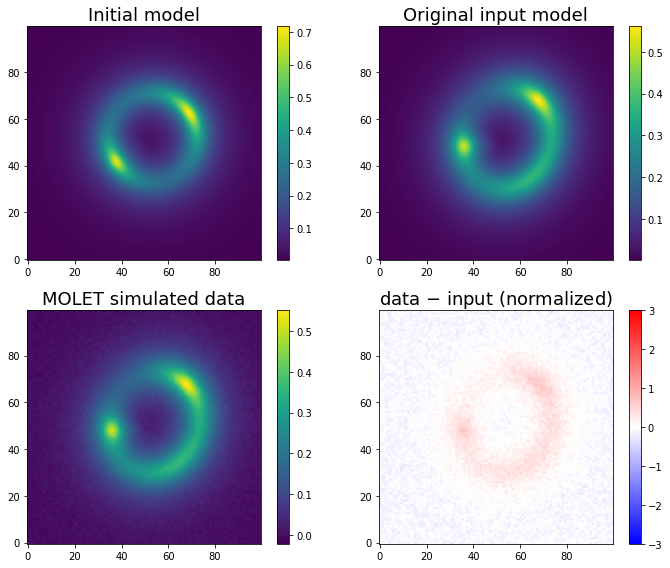

In [9]:
# Generate a lensed image based on source and lens models
lens_image = LensImage(data_class=pixel_grid,
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics={'supersampling_factor': 3})

image = lens_image.model(**kwargs_init)
image_input = lens_image.model(**kwargs_true)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes[0, 0]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(image, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[0, 1]
ax.set_title("Original input model", fontsize=FS)
img = ax.imshow(image_input, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[1, 0]
ax.set_title("MOLET simulated data", fontsize=FS)
img = ax.imshow(data, origin='lower')
fig.colorbar(img, ax=ax)
ax = axes[1, 1]
ax.set_title("data $-$ input (normalized)", fontsize=FS)
img = ax.imshow(data/data.mean()-image_input/image_input.mean(), origin='lower', cmap='bwr', vmin=-3, vmax=3)
fig.colorbar(img, ax=ax)
fig.tight_layout()

print(np.sum((data/data.mean()-image_input/image_input.mean())**2))

### Loss function

In [10]:
loss = Loss(data, lens_image, parameters, likelihood_type='chi2')

### Minimize the loss function

The following method calls `scipy.optimize.mininize`. Supported methods are:
- `'Nelder-Mead'`: uses no analytical gradient;
- `'BFGS'`: uses gradient;
- `'Newton-CG'`/`'trust-krylov'`/`'trust-constr'`: uses gradient and hessian-vector product. In addition, `'trust-constr'` uses bounds from uniform prior consistently within the optimization;
- `'trust-exact'` (uses gradient and hessian).

By setting `use_exact_hessian_if_allowed=True` it is possible to force methods that use the hessian-vector product to use the full hessian instead.

In [11]:
optimizer = Optimizer(loss, parameters)

Check loss and its first derivative evaluated to the true parameters

In [12]:
print(optimizer.loss(p_true))
print(optimizer.jacobian(p_true))

1.8573291469076365
[ 12.238064    -3.97187286   5.62324521  13.06539747   8.25257234
   2.60980425  -9.09886803   2.51772935  25.85633329   7.92299554
 -13.52913435  -9.09346459   2.02494071]


In [13]:
# Optimise !
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
pprint(kwargs_final)
#print(extra_fields['result_class'])  # uncomment for full scipy summary

Runtime: 0.7279038429260254
{'kwargs_lens': [{'center_x': array(-0.00079453),
                  'center_y': array(6.08496439e-05),
                  'e1': array(0.14834421),
                  'e2': array(-0.0406048),
                  'theta_E': array(1.60055894)},
                 {'dec_0': 0.0,
                  'gamma1': array(-0.01083096),
                  'gamma2': array(0.02966108),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'amp': array(-1.10280234)}],
 'kwargs_source': [{'R_sersic': array(1.17387014),
                    'amp': array(10.27015862),
                    'center_x': array(0.39998713),
                    'center_y': array(0.15077007),
                    'n_sersic': array(1.47891997)}]}


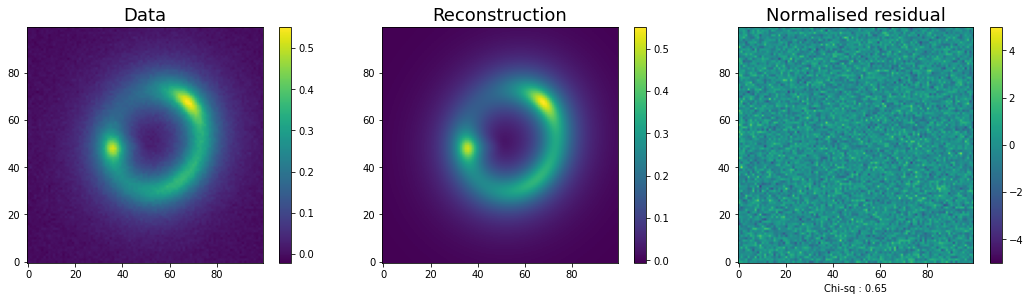

In [14]:
def plot_image_model(kwargs):
    rec = lens_image.model(**kwargs)
    noise_var = lens_image.Noise.C_D

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [15]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_lens_mass):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
    for i, params in enumerate(kwargs_source_light):
        for key, value in params.items():
            fit = kwargs['kwargs_source'][i][key]
            _print_error(key, value, fit)
    for i, params in enumerate(kwargs_lens_light):
        for key, value in params.items():
            fit = kwargs['kwargs_lens_light'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
theta_E:   0.03 % (1.6 => 1.6005589377443799)
e1:        1.10 % (0.15 => 0.14834421013854837)
e2:        -1.51 % (-0.04 => -0.040604800800110884)
center_x:  0.00 [abs] (0.0 => -0.0007945260161595774)
center_y:  0.00 [abs] (0.0 => 6.084964391895191e-05)
gamma1:    -8.31 % (-0.01 => -0.01083095664337053)
gamma2:    1.13 % (0.03 => 0.029661077565255437)
ra_0:      0.00 [abs] (0.0 => 0.0)
dec_0:     0.00 [abs] (0.0 => 0.0)
amp:       2.70 % (10.0 => 10.270158620705745)
R_sersic:  2.18 % (1.2 => 1.1738701398648594)
n_sersic:  1.41 % (1.5 => 1.4789199685432057)
center_x:  0.00 % (0.4 => 0.3999871333099914)
center_y:  0.51 % (0.15 => 0.15077007454920388)
amp:       1.10 [abs] (0.0 => -1.1028023400140012)


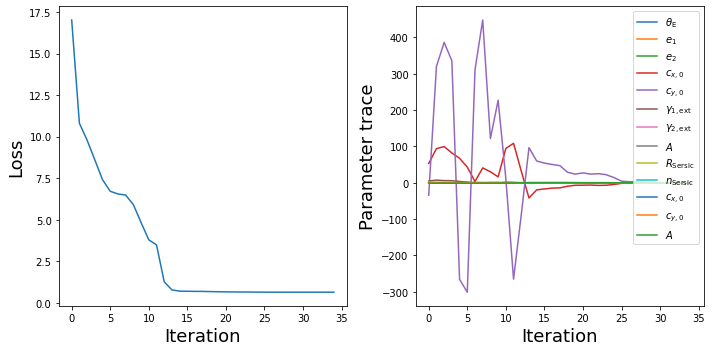

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Check coordinates offsets with MOLET

mass offset, x: -0.0007945260161595774
mass offset, y: 6.084964391895191e-05
source offset, x: -1.2866690008606074e-05
source offset, y: 0.0007700745492038863


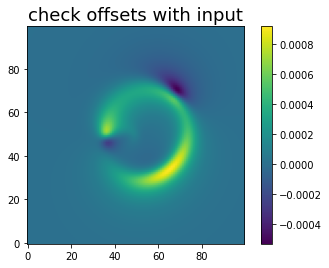

In [17]:
print("mass offset, x:", kwargs_final['kwargs_lens'][0]['center_x'] - kwargs_true['kwargs_lens'][0]['center_x'])
print("mass offset, y:", kwargs_final['kwargs_lens'][0]['center_y'] - kwargs_true['kwargs_lens'][0]['center_y'])
print("source offset, x:", kwargs_final['kwargs_source'][0]['center_x'] - kwargs_true['kwargs_source'][0]['center_x'])
print("source offset, y:", kwargs_final['kwargs_source'][0]['center_y'] - kwargs_true['kwargs_source'][0]['center_y'])

# take optimized parameter but fix all centroids to true input values
kwargs_checkoffset = deepcopy(kwargs_final)
kwargs_checkoffset['kwargs_lens'][0]['center_x'] = kwargs_true['kwargs_lens'][0]['center_x']
kwargs_checkoffset['kwargs_lens'][0]['center_y'] = kwargs_true['kwargs_lens'][0]['center_y']
kwargs_checkoffset['kwargs_source'][0]['center_x'] = kwargs_true['kwargs_source'][0]['center_x']
kwargs_checkoffset['kwargs_source'][0]['center_y'] = kwargs_true['kwargs_source'][0]['center_y']

image_final = lens_image.model(**kwargs_final)
image_checkoffset = lens_image.model(**kwargs_checkoffset)

plt.title("check offsets with input", fontsize=FS)
plt.imshow(image_checkoffset - image_final, origin='lower')
plt.colorbar()
plt.show()

### Fisher matrix & approximated posteriors

Using approximated inverse Hessian


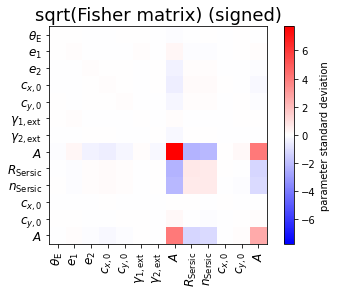

In [18]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
    
else:
    # 1) either we use the true hessian
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)
    
    # 2) or we re-run the BFGS optimizer from the previous estimate to approximate it
    # print("Approximating inverse Hessian with a BFGS run")
    #_, _, extra_fields_bfgs, _ \
    #    = optimizer.minimize(method='BFGS', restart_from_init=False)
    #fisher_matrix = extra_fields_bfgs['hess_inv']

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.xticks(range(parameters.num_parameters), parameters.symbols, rotation='vertical', fontsize=12)
plt.yticks(range(parameters.num_parameters), parameters.symbols, rotation='horizontal', fontsize=12)
plt.colorbar(label="parameter standard deviation")
plt.show()

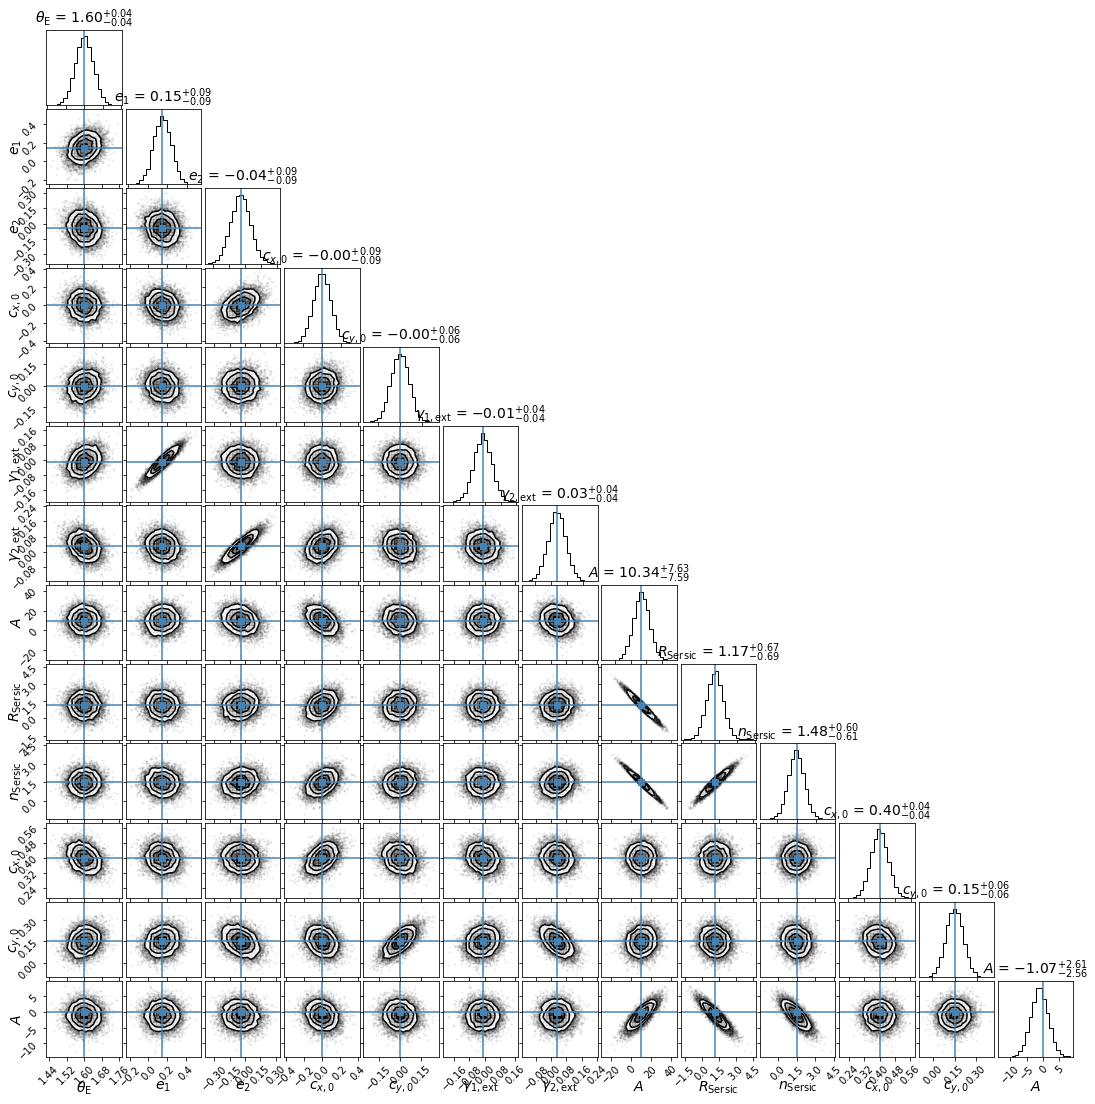

In [19]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

if fisher_matrix is not None:
    samples_fisher = draw_from_gaussian(best_fit, fisher_matrix, ndraws=10000)

    fig = plt.figure(figsize=(15, 15))
    fig = corner.corner(samples_fisher, truths=p_true, show_titles=True, labels=parameters.symbols,
                        #range=0.1*np.array(parameters.bounds).T
                        fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
    plt.show()